# The Problem: High Memory Consumption of LLMs

Deep learning models like **BERT** and **LLaMA** have grown exponentially in size, often containing billions of parameters. In standard training and inference, these parameters are stored in **FP32** (32-bit floating-point) precision.

Since **1 parameter** in FP32 takes up **4 Bytes** of memory, the formula to calculate the Video RAM (VRAM) required to load a model is:

$$
\text{Memory (Bytes)} = \text{Param Count} \times 4
$$

For a model like **LLaMA-2-7B** (which has approx. **7 billion parameters**), the calculation is:

$$
7 \times 10^9 \times 4 \text{ bytes} \approx 28 \text{ GB}
$$

This creates a significant **bottleneck**, as most consumer-grade GPUs (like the NVIDIA T4 in Google Colab or an RTX 3060) only have **12GB to 16GB** of VRAM, making it impossible to load these models natively without optimization techniques.

##  Baseline: Loading a Standard Model

To demonstrate this, we will load the **DistilBERT** model (a smaller, faster version of BERT). By default, Hugging Face loads models in **FP32** precision.

We will calculate its memory footprint using the standard formula:
$$\text{Size} = \text{Total Parameters} \times 4 \text{ Bytes}$$

In [1]:
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer


tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased",num_labels=9)

total_params = sum(p.numel() for p in model.parameters())
    
total_size_bytes = total_params * 4 
total_size_mb = total_size_bytes / (1024 * 1024)
print(f"Memory Footprint (FP32): {total_size_mb:.2f} MB")
     

c:\Users\USER\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading weights: 100%|██████████| 100/100 [00:00<00:00, 191.76it/s, Materializing param=distilbert.transformer.layer.5.sa_layer_norm.weight]   
DistilBertForSequenceClassification LOAD REPORT from: distilbert-base-uncased
Key                     | Status     | 
------------------------+------------+-
vocab_layer_norm.weight | UNEXPECTED | 
vocab_layer_norm.bias   | UNEXPECTED | 
vocab_transform.weight  | UNEXPECTED | 
vocab_transform.bias    | UNEXPECTED | 
vocab_projector.bias    | UNEXPECTED | 
classifier.bias         | MISSING    | 
classifier.weight       | MISSING    | 
pre_classifier.bias     | MISSING    | 
pre_classifier.weight   | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from differ

Memory Footprint (FP32): 255.43 MB


##  The Solution: Quantization

**Quantization** is a technique to reduce the computational and memory costs of running inference by representing weights and activations with low-precision data types like **8-bit integers (INT8)** instead of the usual 32-bit floating point (FP32).

To understand how we shrink a model, we need to understand how **Affine Quantization** maps a wide range of floating-point numbers (like `-3.4` to `+2.5`) into a tiny range of integers (like `0` to `255`).
### The Math of Quantization
####  The Variables
* **$x$ (Input):** The original weight in the model (FP32).
* **$x_q$ (Quantized):** The new integer value (INT8).
* **$S$ (Scale):** The "step size". It tells us how much value one single integer step represents.
* **$Z$ (Zero Point):** The integer value that maps exactly to the real number `0.0`. This is crucial because neural networks have many zeros (padding, ReLU outputs), and we must represent `0` exactly to avoid errors.

####  Calculating Scale ($S$) and Zero Point ($Z$)
First, we find the minimum ($\alpha$) and maximum ($\beta$) values in the weight tensor. Then we determine the range of our integer type (for 8-bit, it is $0$ to $255$).

**Step A: Calculate Scale ($S$)**
$$S = \frac{\beta - \alpha}{2^b - 1}$$
*(Where $b$ is the number of bits. For 8-bit, $2^8 - 1 = 255$)*

**Step B: Calculate Zero Point ($Z$)**
$$Z = \text{round}\left( - \frac{\alpha}{S} \right)$$

#### The Conversion Formulas

**Quantization (Float $\rightarrow$ Int):**
To turn a weight into an integer, we divide by the scale, shift it by the zero point, and round it.
$$x_q = \text{round}\left( \frac{x}{S} + Z \right)$$

**Dequantization (Int $\rightarrow$ Float):**
To use the weight during inference, the computer quickly converts it back (approximated).
$$x \approx S(x_q - Z)$$


### Benefits
1.  **Memory Reduction:** INT8 takes **4x less RAM** than FP32.
2.  **Speed:** Integer operations are faster on modern CPUs.
3.  **Efficiency:** Allows running Large Language Models (LLMs) on consumer hardware.

In [3]:
import torch


q=torch.ao.quantization.quantize_dynamic(model, qconfig_spec={torch.nn.Linear}, dtype=torch.qint8, mapping=None, inplace=False)
param_size = sum(p.numel() * p.element_size() for p in model.parameters())
buffer_size = sum(b.numel() * b.element_size() for b in model.buffers())
     
def get_size(model):
    param_size = sum(p.numel() * p.element_size() for p in model.parameters())
    buffer_size = sum(b.numel() * b.element_size() for b in model.buffers())
    return (param_size + buffer_size) / 1024**2

original_size = get_size(model)
quantized_size = get_size(q)
print(f"Original Size:  {original_size:.2f} MB")
print(f"Quantized Size: {quantized_size:.2f} MB")
print(f"Reduction:      {original_size / quantized_size:.1f}x smaller")

C:\Users\USER\AppData\Local\Temp\ipykernel_16792\2962352133.py:4: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  q=torch.ao.quantization.quantize_dynamic(model, qconfig_spec={torch.nn.Linear}, dtype=torch.qint8, mapping=None, inplace=False)


Original Size:  255.44 MB
Quantized Size: 91.00 MB
Reduction:      2.8x smaller


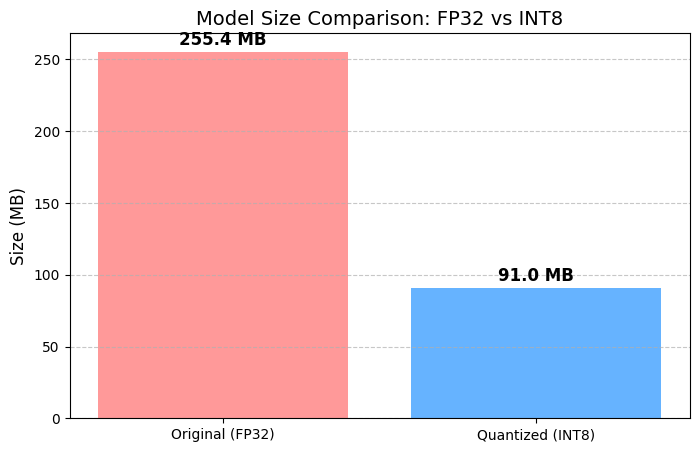

: 

In [ ]:
import matplotlib.pyplot as plt

methods = ['Original (FP32)', 'Quantized (INT8)']
sizes = [original_size, quantized_size]
colors = ['#ff9999', '#66b3ff'] 

plt.figure(figsize=(8, 5))
bars = plt.bar(methods, sizes, color=colors)

plt.title('Model Size Comparison: FP32 vs INT8', fontsize=14)
plt.ylabel('Size (MB)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 2, 
             f'{height:.1f} MB', ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.show()

##  Conclusion

In this experiment, we demonstrated that **Dynamic Quantization** significantly reduces the memory footprint of a Transformer model. 

* We successfully reduced the model size from **~255 MB** to **~91 MB**.
* This represents a **2.8x reduction** in memory usage.
* This optimization allows large models to fit onto smaller devices (like laptops or mobile phones) with minimal loss in accuracy.